In [ ]:
import os
root_path = '/raid/ee-mariyam/maryam/abhijeet/Combined_Files'
def get_jpg_paths(base_dir):
    jpg_dict = {}
    
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.isdir(folder_path):
            jpg_paths = []
            
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith('.jpg'):
                    file_path = os.path.join(folder_path, file_name)
                    jpg_paths.append(file_path)
            
            if jpg_paths:
                jpg_dict[folder_name] = jpg_paths
    
    return jpg_dict

combined_files_path = root_path
jpg_paths_dict = get_jpg_paths(combined_files_path)


In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F 
import cv2
from PIL import Image


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return all_labels, all_preds



In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, num_classes, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
def plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_classwise_accuracy(cm, jpg_paths_dict):
    total_accuracy = np.trace(cm) / np.sum(cm)

    classwise_accuracy = cm.diagonal() / cm.sum(axis=1)

    class_names = list(jpg_paths_dict.keys())  
    classwise_accuracy = [
        acc if cm.sum(axis=1)[i] > 0 else np.nan
        for i, acc in enumerate(classwise_accuracy)
    ]

    print(f"Total Accuracy: {total_accuracy * 100:.2f}%")
    for i, accuracy in enumerate(classwise_accuracy):
        if np.isnan(accuracy):
            print(f"Class '{class_names[i]}' Accuracy: N/A (no samples)")
        else:
            print(f"Class '{class_names[i]}' Accuracy: {accuracy * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, classwise_accuracy, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 1)  
    plt.axhline(total_accuracy, color='red', linestyle='--', label='Total Accuracy')
    plt.xticks(rotation=45) 
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout() 
    plt.show()

In [9]:
for subfolder, jpg_files in jpg_paths_dict.items():
    print(f"Subfolder: {subfolder}")
    print(f"Number of JPEG files: {len(jpg_files)}")
    print()

Subfolder: Purple_Blotch
Number of JPEG files: 406

Subfolder: Thrips
Number of JPEG files: 546

Subfolder: IYSV
Number of JPEG files: 754

Subfolder: Twister
Number of JPEG files: 317

Subfolder: Healthy
Number of JPEG files: 1072

Subfolder: Bulb Rot
Number of JPEG files: 669

Subfolder: Basal_Rot
Number of JPEG files: 140

Subfolder: Stemphylium
Number of JPEG files: 661

Subfolder: Anthracnose
Number of JPEG files: 765



In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, jpg_files_dict, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        self._prepare_data(jpg_files_dict)

    def _prepare_data(self, jpg_files_dict):
        for label_idx, (subfolder, file_paths) in enumerate(jpg_files_dict.items()):
            self.label_map[subfolder] = label_idx
            for file_path in file_paths:
                self.image_paths.append(file_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f'Error loading image {img_path}: {e}')
            image = Image.new('RGB', (224, 224))
            label = self.labels[idx]
        else:
            label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, jpg_files_dict, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        self._prepare_data(jpg_files_dict)

    def _prepare_data(self, jpg_files_dict):
        for label_idx, (subfolder, file_paths) in enumerate(jpg_files_dict.items()):
            self.label_map[subfolder] = label_idx
            for file_path in file_paths:
                self.image_paths.append(file_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f'Error loading image {img_path}: {e}')
            image = Image.new('RGB', (224, 224))
            label = self.labels[idx]
        else:
            label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

jpg_paths_comb_dict = jpg_paths_dict.copy()
anthra = jpg_paths_comb_dict['Anthracnose']
twist = jpg_paths_comb_dict['Twister']
antra_twist = anthra+twist
jpg_paths_comb_dict['Antracnose_Twister'] = antra_twist

jpg_paths_comb_dict.pop('Anthracnose', None)
jpg_paths_comb_dict.pop('Twister', None)

for subfolder, jpg_files in jpg_paths_comb_dict.items():
    print(f"Subfolder: {subfolder}")
    print(f"Number of JPEG files: {len(jpg_files)}")
    print()
dataset = CustomImageDataset(jpg_files_dict=jpg_paths_comb_dict, transform=transform)



Subfolder: Purple_Blotch
Number of JPEG files: 406

Subfolder: Thrips
Number of JPEG files: 546

Subfolder: IYSV
Number of JPEG files: 754

Subfolder: Healthy
Number of JPEG files: 1072

Subfolder: Bulb Rot
Number of JPEG files: 669

Subfolder: Basal_Rot
Number of JPEG files: 140

Subfolder: Stemphylium
Number of JPEG files: 661

Subfolder: Antracnose_Twister
Number of JPEG files: 1082



In [11]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=64)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=64)


In [12]:

import numpy as np
import torch
class_counts = []
for subfolder, jpg_files in jpg_paths_comb_dict.items():
    class_counts.append(len(jpg_files))
def compute_class_weights(label_map, dataset):
    print(class_counts)
    class_weights = np.max(class_counts) / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(class_weights)
    return class_weights

class_weights = compute_class_weights(dataset.label_map, dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights)


[406, 546, 754, 1072, 669, 140, 661, 1082]
tensor([2.6650, 1.9817, 1.4350, 1.0093, 1.6173, 7.7286, 1.6369, 1.0000],
       device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

model = models.vit_b_16(pretrained=True)

num_classes = len(jpg_paths_comb_dict)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion =criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects / total

        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_corrects += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs} '
              f'Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_acc:.4f} '
              f'Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'denset121_ViT.pth')
            print(f'Saved best model with accuracy: {best_acc:.4f}')

    print('Training complete.')
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies



In [28]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)


Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet

Traceback (most recent call last):
Traceback (most recent call last):
  File "/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] B

Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
Epoch 6/50 Train Loss: 0.9720 Train Accuracy: 0.6508 Val Loss: 0.9980 Val Accuracy: 0.6445
Saved best model with accuracy: 0.6445
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotc

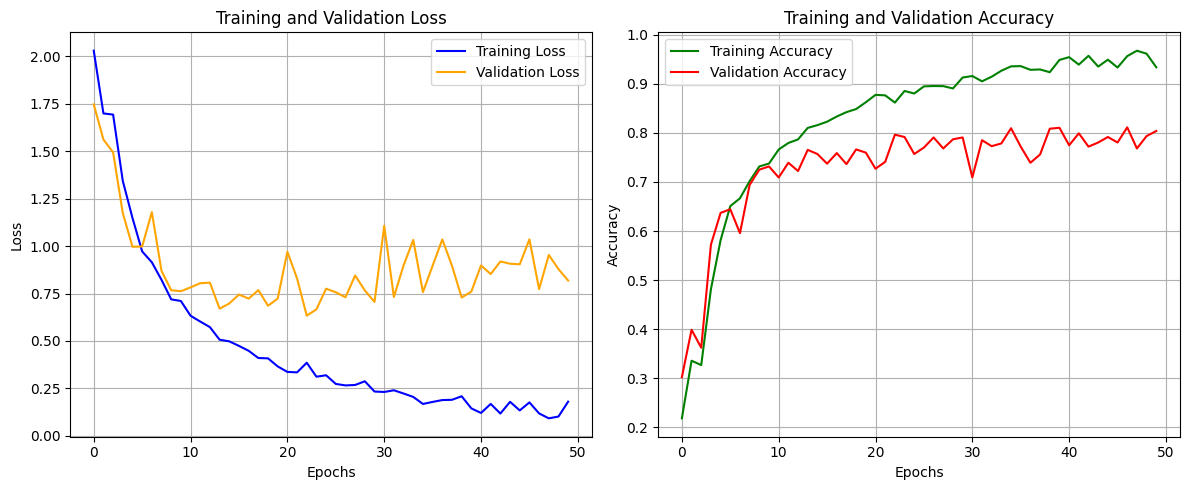

In [29]:
plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

In [30]:
model.load_state_dict(torch.load('denset121_ViT.pth'))
all_labels, all_preds = evaluate_model(model, val_loader)

Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file


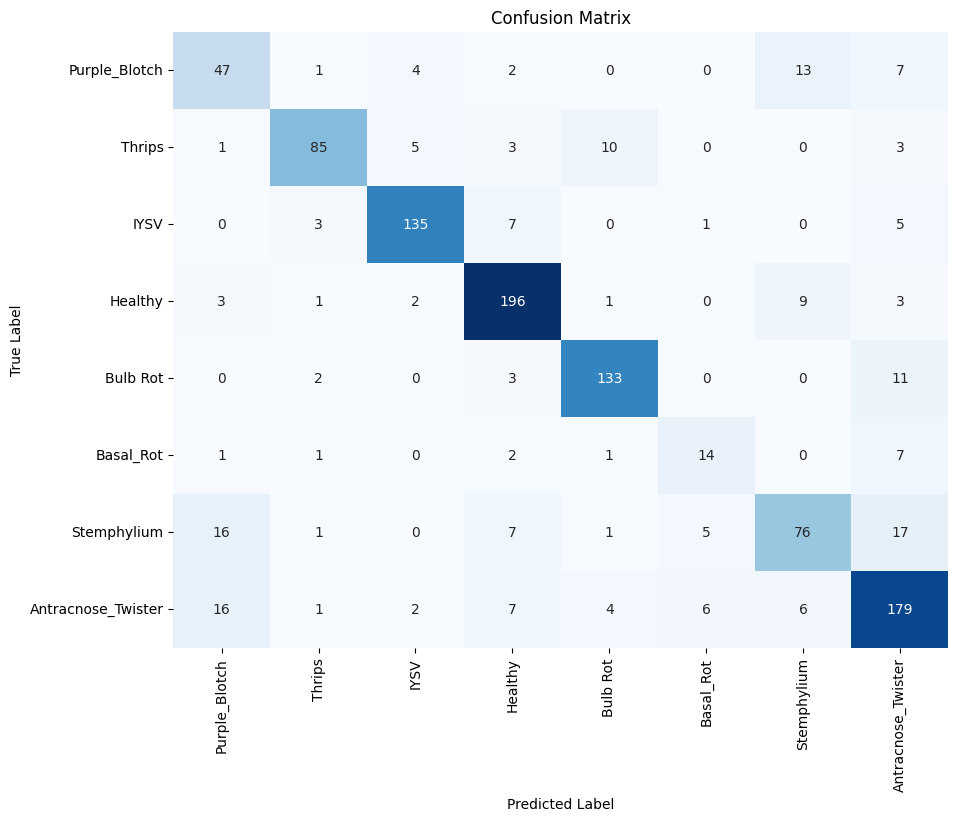

In [31]:
cm = confusion_matrix(all_labels, all_preds)
class_names = jpg_paths_comb_dict.keys()
num_classes=len(jpg_paths_comb_dict)
plot_confusion_matrix(cm, num_classes , class_names )

Total Accuracy: 81.14%
Class 'Purple_Blotch' Accuracy: 63.51%
Class 'Thrips' Accuracy: 79.44%
Class 'IYSV' Accuracy: 89.40%
Class 'Healthy' Accuracy: 91.16%
Class 'Bulb Rot' Accuracy: 89.26%
Class 'Basal_Rot' Accuracy: 53.85%
Class 'Stemphylium' Accuracy: 61.79%
Class 'Antracnose_Twister' Accuracy: 81.00%


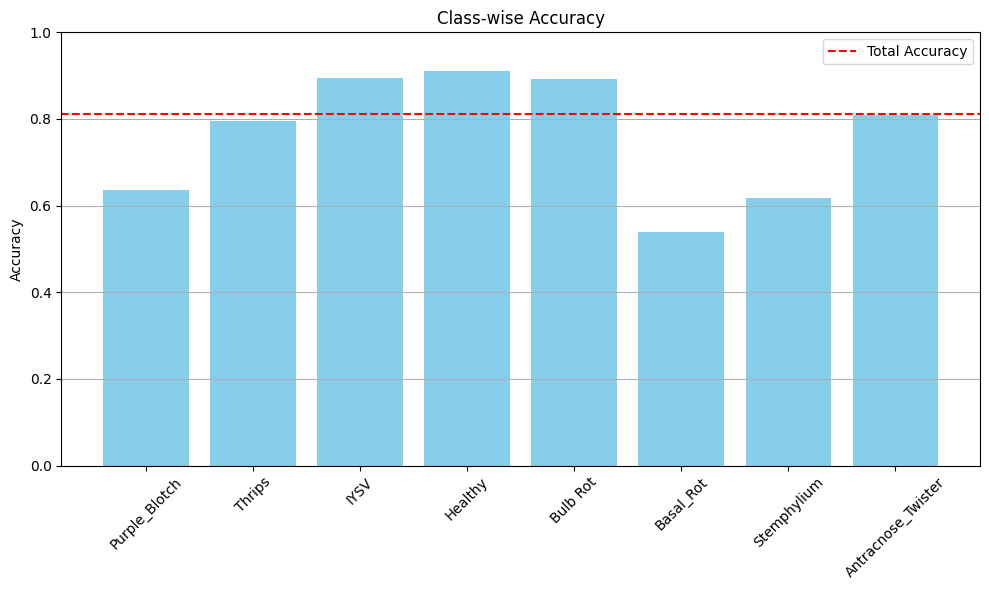

In [32]:
plot_classwise_accuracy(cm, jpg_paths_comb_dict)